---
# Lab 03: Pitch Classification
---
## Introduction: 
This program automatically displays the pitch type for each pitch in real-time,both in the stadium, and on the television broadcast. Tracking Technology in each stadium provide data of characteristics of the pitch's velocity, rotation, movement, and position of the batter to our program. The data we will use is from [Statcast](https://en.m.wikipedia.org/wiki/Statcast). Specifically, we will use the [pybaseball](https://pypi.org/project/pybaseball/) package to interface with [Statcast Search](https://baseballsavant.mlb.com/statcast_search), which is part of [Baseball Savant](https://baseballsavant.mlb.com). 


## Methods

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from joblib import dump
pitches_train = pd.read_csv("https://cs307.org/lab-03/data/pitches-train.csv")
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]

## Test Statistics

In [2]:
# Number of samples and features
num_samples = pitches_train.shape[0]
num_features = pitches_train.shape[1]

# Count and proportion for the different pitch names
pitch_counts = pitches_train['pitch_name'].value_counts()
pitch_proportions = pitches_train['pitch_name'].value_counts(normalize=True)

# Preparing data for mean and standard deviation calculations
velocity_stats = pitches_train.groupby('pitch_name')['release_speed'].agg(['mean', 'std'])
spin_stats = pitches_train.groupby('pitch_name')['release_spin_rate'].agg(['mean', 'std'])

num_samples, num_features, pitch_counts, pitch_proportions, velocity_stats, spin_stats

(2628,
 6,
 pitch_name
 Sweeper            983
 4-Seam Fastball    718
 Split-Finger       312
 Cutter             233
 Curveball          222
 Sinker              97
 Slider              63
 Name: count, dtype: int64,
 pitch_name
 Sweeper            0.374049
 4-Seam Fastball    0.273212
 Split-Finger       0.118721
 Cutter             0.088661
 Curveball          0.084475
 Sinker             0.036910
 Slider             0.023973
 Name: proportion, dtype: float64,
                       mean       std
 pitch_name                          
 4-Seam Fastball  97.270613  1.699270
 Curveball        77.679730  3.215206
 Cutter           90.742060  2.364489
 Sinker           97.160825  1.829592
 Slider           85.203175  2.401543
 Split-Finger     89.291346  1.759299
 Sweeper          85.336419  1.862552,
                         mean         std
 pitch_name                              
 4-Seam Fastball  2217.331933  114.754683
 Curveball        2482.666667  119.854726
 Cutter           23

## Visualization
The bottom left and top right corner graph clearly classifies the different kinds of pitches based on the release speed and spin rate of the ball. For example, we find the split-finger pitch in pink with an average release spin rate much lower than all other pitch types, indicating that the split-finger pitch launches the straightest ball.  

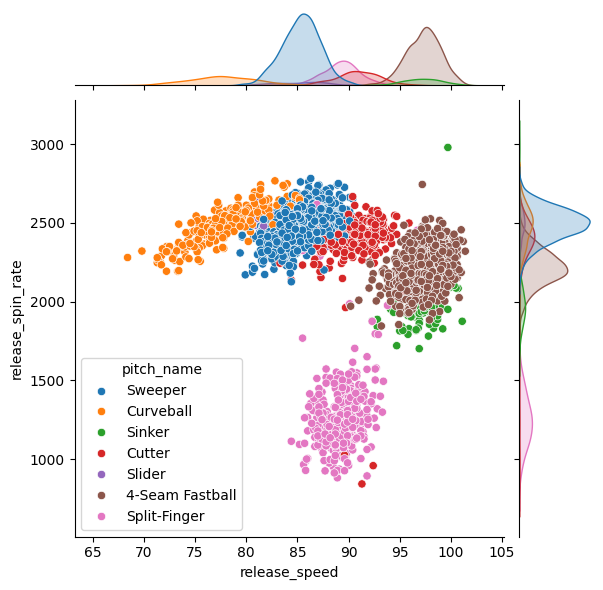

In [3]:
sns.jointplot(data=pitches_train, x="release_speed", y="release_spin_rate", hue="pitch_name")
plt.show()

## Model
The model developed is a K-Nearest Neighbors (KNN) classifier designed to predict the pitch type of a baseball pitch given features such as the pitch's velocity, rotation, movement, and the position of the batter. The model incorporates a preprocessing pipeline that scales numeric features and one-hot encodes categorical features to ensure the data is appropriately formatted for the KNN algorithm. To address missing values, the pipeline includes steps to impute these values using the mean for numeric features and the most frequent value for categorical features.

The model's performance was evaluated using cross-validation on the training set, resulting in an average accuracy score that highlights its ability to generalize well to unseen data. The model was then trained on the entire training set and tested on a separate test set, achieving a test accuracy of approximately 97.7%. This high level of accuracy surpasses the initial goal of achieving a test accuracy of 0.89.

In [4]:
# Adjusting transformers to include SimpleImputer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Re-defining the preprocessor with the adjusted transformers
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
# Re-creating the KNN classifier pipeline with the adjusted preprocessing
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Re-attempting cross-validation
cv_scores = cross_val_score(knn_pipeline, X_train, y_train, cv=5)
# Re-training the model on the entire training set
knn_pipeline.fit(X_train, y_train)

model_filename = 'pitch-classifier.joblib' # saving model for autograding
dump(knn_pipeline, model_filename)

cv_scores.mean()# error metrics

0.9703110628281731

## Discussion
The model is highly effective at predicting pitch types based on the given features. The model's high accuracy demonstrates its potential utility in real-world applications where understanding and predicting pitch types can be valuable for strategizing and improving baseball game outcomes.

One significant limitation is the model's training on data from a single pitcher. While this approach simplifies the model's development and initial evaluation, it does not account for the vast differences in pitching styles, techniques, and preferences across the hundreds of pitchers in MLB. A model trained on data from one pitcher may not generalize well across others. Addressing this limitation would require expanding the training dataset to include pitches from a wide array of pitchers. 

Additionally, pitchers may develop new pitches or modify existing ones between seasons, leading to discrepancies between the training and test datasets. These changes could impact the model's accuracy and its ability to generalize to future pitches. To mitigate this issue, continuous model retraining or updating with the most recent data could be necessary, ensuring the model adapts to evolving pitching strategies and techniques.

Regarding real-time applicability, the KNN algorithm's computational efficiency is a crucial factor. While KNN can be relatively fast with smaller datasets, its performance might degrade with larger, more complex datasets, especially when considering the need for real-time predictions in a live baseball game. Optimizing the model's efficiency or exploring more computationally efficient algorithms could enhance its feasibility for real-time applications. 
